В этом файле будем работать с собранными данными, выявлять статистические закономерности и искать возможности для арбитража.
Наши задачи:
Возможные нюансы:

In [2]:
#импортируем необходимые библиотеки
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import time
import pandas as pd
import io
from io import StringIO
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
#обрабатываем финальный датасет, создаем дополнительные признаки
df_to_clear = pd.read_excel(r'C:\Users\Maksim\Desktop\Python VSC\IDE\PROJECT FOR WORK\fouls\Italy\df_to_clear_italy.xlsx')
df_to_clear = df_to_clear.replace({'Inter': 'Internazionale', 'Dynamo Mosc': 'Dynamo Moscow', 'Loko Moscow': 'Lokomotiv Moscow' })
final_df_to_ml = df_to_clear.sort_values(['Date', 'Home'])
final_df = final_df_to_ml[(final_df_to_ml['fouls_home'].notna()) & (final_df_to_ml['fouls_home'] != 0)]
final_df.describe()
final_df['fouls_total'] = final_df['fouls_home'] + final_df['fouls_away']
final_df['fouls_diff'] = final_df['fouls_home'] - final_df['fouls_away']

C:\Users\Maksim\AppData\Local\Temp\ipykernel_15176\1325215676.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['fouls_total'] = final_df['fouls_home'] + final_df['fouls_away']
C:\Users\Maksim\AppData\Local\Temp\ipykernel_15176\1325215676.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['fouls_diff'] = final_df['fouls_home'] - final_df['fouls_away']


In [5]:
#проверим наш датафрейм
print(final_df.describe())
final_df[final_df['Home'] == 'Internazionale']

       fouls_home  fouls_away  fouls_total  fouls_diff
count  383.000000  383.000000   383.000000  383.000000
mean    11.785901   12.467363    24.253264   -0.681462
std      3.403280    3.511888     5.111437    4.658814
min      3.000000    4.000000     8.000000  -15.000000
25%      9.000000   10.000000    21.000000   -4.000000
50%     12.000000   12.000000    24.000000    0.000000
75%     14.000000   15.000000    28.000000    3.000000
max     23.000000   25.000000    38.000000   13.000000


,Date,Home,Away,Referee,fouls_home,fouls_away,fouls_total,fouls_diff
2,2023-08-19,Internazionale,Monza,Andrea Colombo,8.0,13.0,21.0,-5.0
26,2023-09-03,Internazionale,Fiorentina,Matteo Marchetti,13.0,12.0,25.0,1.0
30,2023-09-16,Internazionale,Milan,Simone Sozza,16.0,13.0,29.0,3.0
54,2023-09-27,Internazionale,Sassuolo,Luca Massimi,10.0,8.0,18.0,2.0
69,2023-10-07,Internazionale,Bologna,Marco Guida,11.0,9.0,20.0,2.0
92,2023-10-29,Internazionale,Roma,Fabio Maresca,14.0,9.0,23.0,5.0
114,2023-11-12,Internazionale,Frosinone,Federico Dionisi,7.0,16.0,23.0,-9.0
136,2023-12-09,Internazionale,Udinese,Marco Di Bello,9.0,6.0,15.0,3.0
159,2023-12-23,Internazionale,Lecce,Matteo Marcenaro,8.0,14.0,22.0,-6.0
172,2024-01-06,Internazionale,Hellas Verona,Michael Fabbri,16.0,15.0,31.0,1.0


In [6]:
#создадим табличку для судей
referee_stats = final_df.groupby('Referee', as_index= False)[['fouls_total', 'fouls_diff']].agg(['mean', 'count']).sort_values(by=[('fouls_total', 'count'),('fouls_total', 'mean')], ascending=False)
referee_stats['mean_of_means'] = referee_stats[('fouls_total','mean')].mean()
referee_stats.columns
referee_stats['mean_dif'] = referee_stats[('fouls_total', 'mean')] - referee_stats['mean_of_means']
referee_stats = referee_stats[[(      'Referee',      ''),(  'fouls_total', 'count'),(  'fouls_total',  'mean'),('mean_of_means',      ''),('mean_dif', ''), (   'fouls_diff',  'mean')]]
referee_stats

Referee fouls_total            mean_of_means  mean_dif  \
                                     count       mean                           
7               Daniele Orsato          16  23.375000     23.983878 -0.608878   
10                Davide Massa          15  26.800000     23.983878  2.816122   
22                 Juan Sacchi          15  25.600000     23.983878  1.616122   
12               Fabio Maresca          15  25.333333     23.983878  1.349455   
6               Daniele Doveri          15  24.600000     23.983878  0.616122   
14           Federico La Penna          15  24.066667     23.983878  0.082788   
2               Andrea Colombo          15  23.866667     23.983878 -0.117212   
33            Maurizio Mariani          15  23.800000     23.983878 -0.183878   
28                 Marco Guida          15  23.533333     23.983878 -0.450545   
4              Antonio Rapuano          14  25.928571     23.983878  1.944693   
25               Luca Pairetto          13  22.846154     23.983878 -1.137724   
11           Ermanno Feliciani          13  22.384615     23.983878 -1.599263   
34              Michael Fabbri          12  24.750000     23.983878  0.766122   
18        Gianluca Manganiello          12  22.333333     23.983878 -1.650545   
31            Matteo Marcenaro          12  22.250000     23.983878 -1.733878   
17          Gianluca Aureliano          11  26.181818     23.983878  2.197940   
29             Marco Piccinini          11  23.272727     23.983878 -0.711151   
27              Marco Di Bello          11  23.181818     23.983878 -0.802060   
37                Simone Sozza          10  26.800000     23.983878  2.816122   
3                 Antonio Giua          10  24.100000     23.983878  0.116122   
32            Matteo Marchetti          10  23.600000     23.983878 -0.383878   
13            Federico Dionisi           9  27.888889     23.983878  3.905011   
1          Alessandro Prontera           9  22.222222     23.983878 -1.761656   
5               Daniele Chiffi           9  22.222222     23.983878 -1.761656   
19            Giovanni Ayroldi           8  26.125000     23.983878  2.141122   
24                Luca Massimi           8  25.125000     23.983878  1.141122   
23             Livio Marinelli           8  24.375000     23.983878  0.391122   
30  Maria Sole Ferrieri Caputi           8  23.125000     23.983878 -0.858878   
36              Rosario Abisso           6  24.166667     23.983878  0.182788   
16          Francesco Fourneau           5  21.800000     23.983878 -2.183878   
26               Luca Zufferli           5  21.400000     23.983878 -2.583878   
0              Alberto Santoro           3  26.666667     23.983878  2.682788   
35            Paride Tremolada           3  25.666667     23.983878  1.682788   
8              Davide Di Marco           2  21.000000     23.983878 -2.983878   
20              Giuseppe Collu           2  21.000000     23.983878 -2.983878   
9              Davide Ghersini           1  26.000000     23.983878  2.016122   
21                Ivan Pezzuto           1  24.000000     23.983878  0.016122   
15             Francesco Cosso           1  20.000000     23.983878 -3.983878   

   fouls_diff  
         mean  
7   -3.250000  
10   0.800000  
22  -1.466667  
12   0.400000  
6   -0.466667  
14   1.800000  
2   -0.533333  
33  -0.600000  
28   1.266667  
4   -1.214286  
25  -0.692308  
11   0.230769  
34   0.416667  
18  -0.166667  
31  -2.750000  
17  -0.181818  
29  -1.454545  
27  -2.090909  
37   3.200000  
3   -1.300000  
32  -1.800000  
13  -5.666667  
1    0.222222  
5    0.444444  
19  -1.125000  
24  -2.375000  
23   3.375000  
30  -0.375000  
36   0.500000  
16  -2.200000  
26  -3.400000  
0   -0.666667  
35   0.333333  
8   -7.000000  
20  -4.000000  
9   -2.000000  
21  -6.000000  
15  -4.000000

c:\Users\Maksim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Maksim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Maksim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Maksim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Maksim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.d

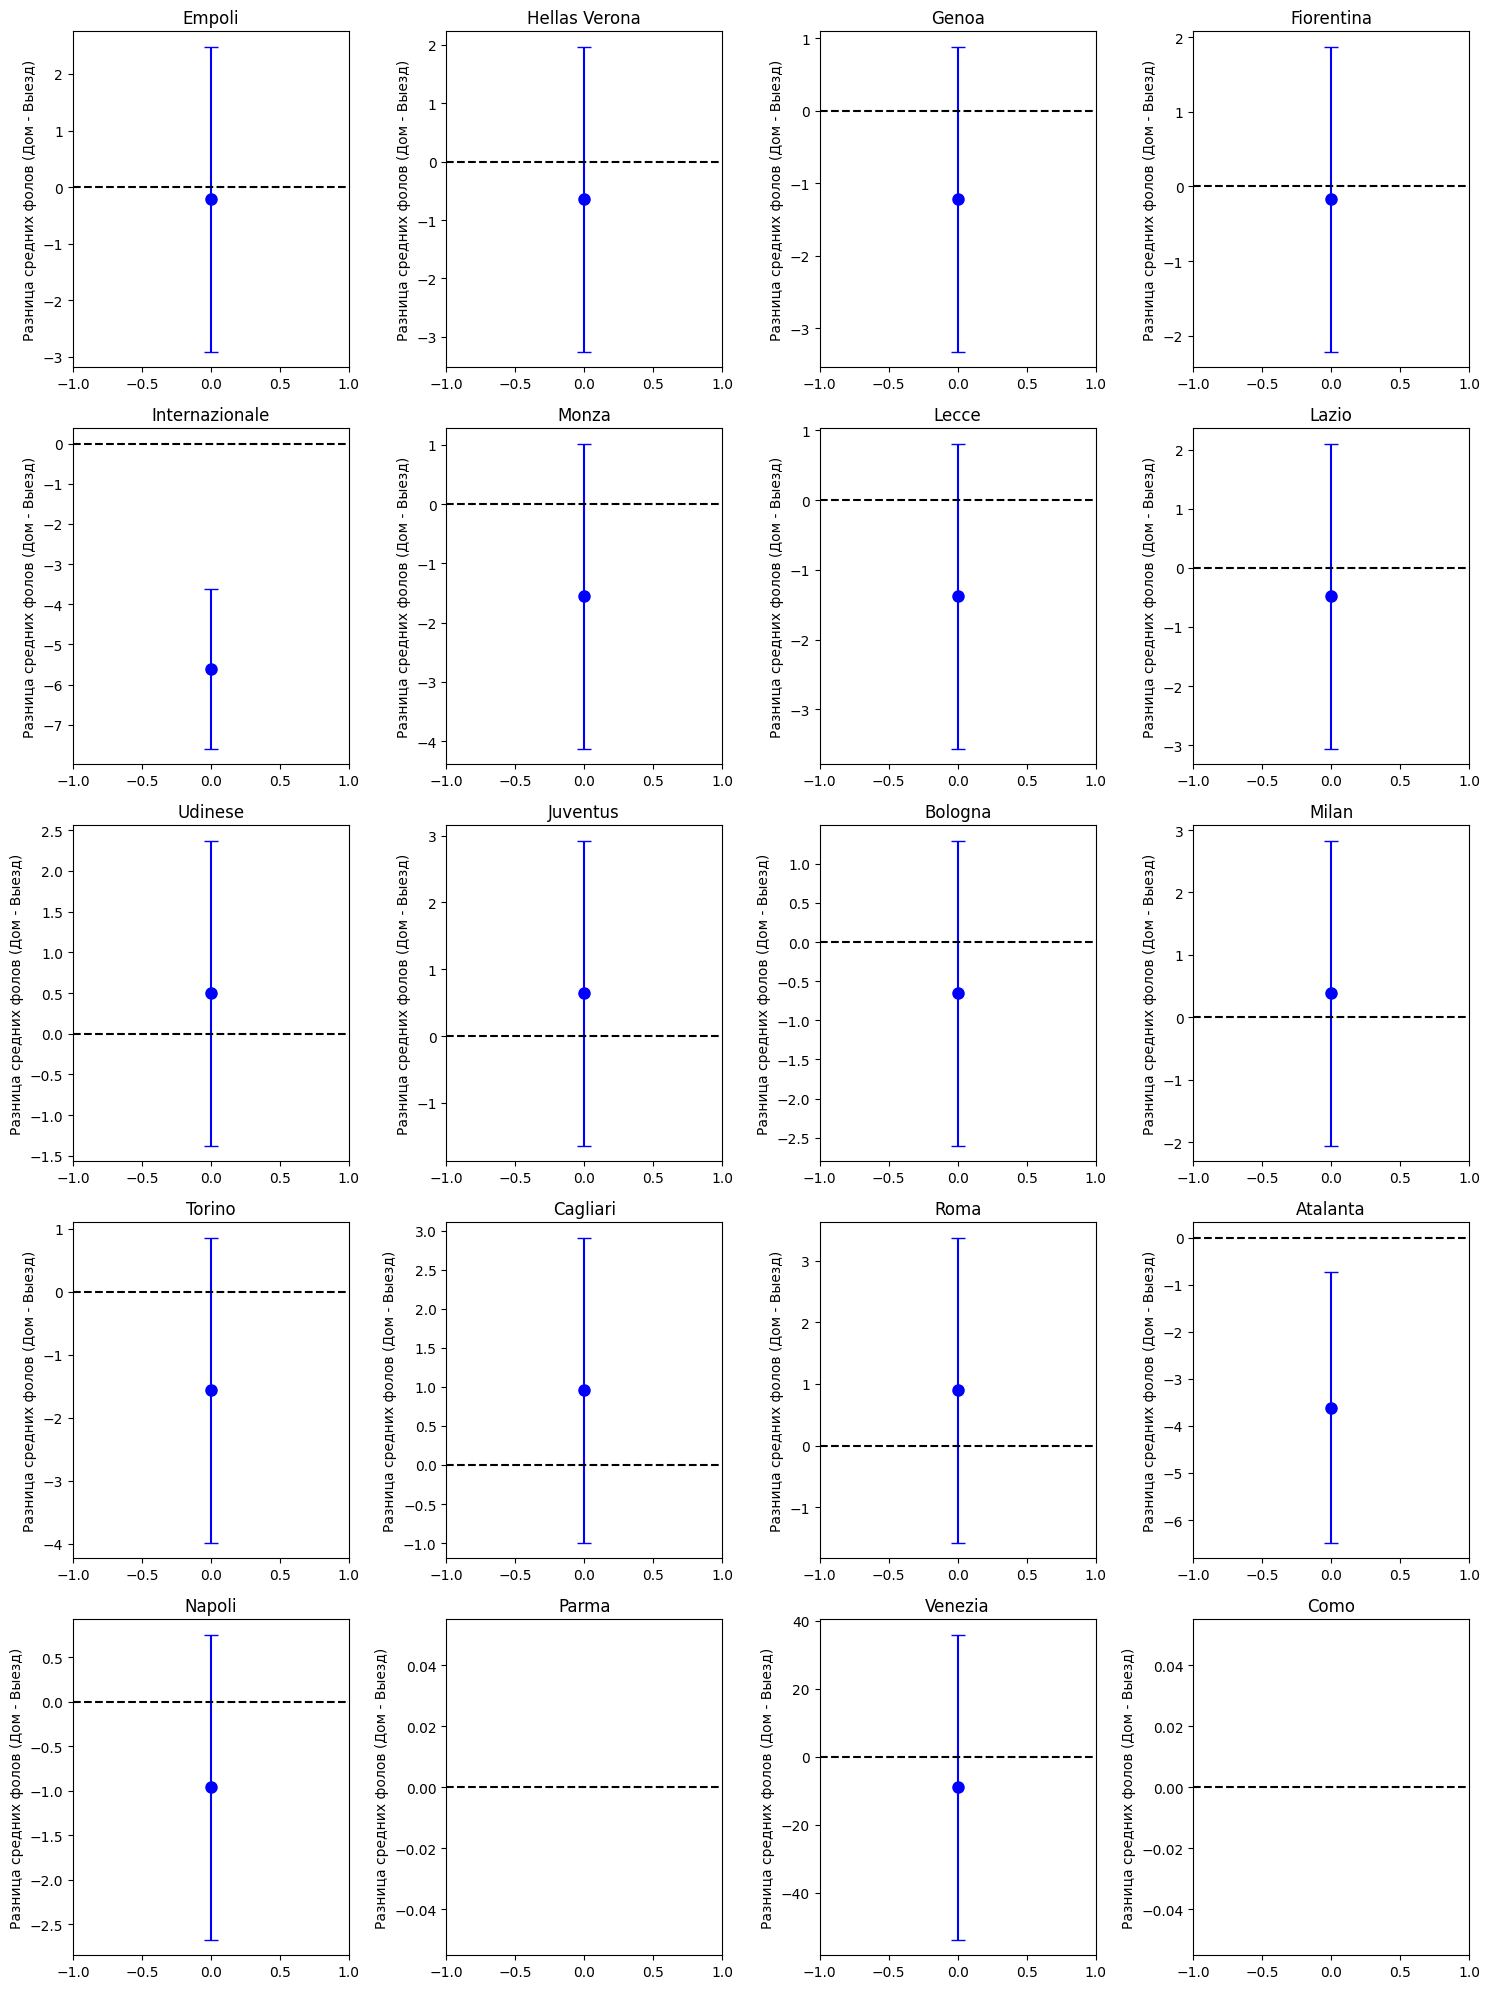

In [7]:
#посмотрим, есть ли стат. значимые различия для игр дома и на выезде, чтобы понять, можем ли для прогноза мы использовать все данные или только в разрезе дома/в гостях, построим графики дов.интервалов для разницы фолов дома и фолов в гостях и проверим там наличие 0.
%matplotlib inline
# Создаём словарь для хранения фолов команд дома и на выезде
teams_to_delete = ['Frosinone', 'Sassuolo', 'Salernitana']
final_df_pure = final_df[~final_df.isin(teams_to_delete).any(axis=1)]
team_fouls = {}
for index, row in final_df_pure.iterrows():
    home_team = row['Home']
    away_team = row['Away']
    home_fouls = row['fouls_home']
    away_fouls = row['fouls_away']

    if home_team not in team_fouls:
        team_fouls[home_team] = {'Home': [], 'Away': []} # Изменили ключи словаря
    if away_team not in team_fouls:
        team_fouls[away_team] = {'Home': [], 'Away': []} # Изменили ключи словаря

    team_fouls[home_team]['Home'].append(home_fouls) # Изменили ключи словаря
    team_fouls[away_team]['Away'].append(away_fouls) # Изменили ключи словаря

# Уровень доверия
confidence_level = 0.95

# Определяем количество строк и столбцов для сабплотов
n_teams = len(team_fouls)
n_cols = 4
n_rows = (n_teams + n_cols - 1) // n_cols

# Создаём фигуру и оси для сабплотов
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

# Индекс для перебора сабплотов
plot_index = 0

# Цикл по командам
for team, fouls_data in team_fouls.items():
    # Определяем текущие строку и столбец для сабплота
    row = plot_index // n_cols
    col = plot_index % n_cols

    # Вычисляем доверительный интервал
    n1 = len(fouls_data['Home']) # Изменили ключи словаря
    n2 = len(fouls_data['Away']) # Изменили ключи словаря
    mean_diff = np.mean(fouls_data['Home']) - np.mean(fouls_data['Away']) # Изменили ключи словаря
    std_diff = np.sqrt(np.var(fouls_data['Home'])/n1 + np.var(fouls_data['Away'])/n2) # Изменили ключи словаря
    t_crit = stats.t.ppf((1 + confidence_level) / 2, df=n1+n2-2)
    margin_of_error = t_crit * std_diff
    confidence_interval = (mean_diff - margin_of_error, mean_diff + margin_of_error)

    # Строим график доверительного интервала
    axes[row, col].errorbar(x=0, y=mean_diff, yerr=margin_of_error, 
                             fmt='o', capsize=5, color='blue', markersize=8)
    axes[row, col].axhline(y=0, color='black', linestyle='--')
    axes[row, col].set_xlim([-1, 1]) 
    axes[row, col].set_title(f'{team}')
    axes[row, col].set_ylabel('Разница средних фолов (Дом - Выезд)')

    plot_index += 1

# Удаляем пустые сабплоты
if plot_index < n_rows * n_cols:
    for i in range(plot_index, n_rows * n_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

Как мы видим, данные статистически не различимы для большинства команд, однако, у некоторых нет.

In [9]:
#Далее проведем тесты на нормальность распределений

import pandas as pd
from collections import defaultdict
import scipy.stats as stats
import numpy as np

alpha = 0.05  # Уровень значимости для тестов

all_teams_fouls = {}

# Итерируемся по строкам DataFrame
for index, row in final_df_pure.iterrows():
    home_team = row['Home']
    away_team = row['Away']
    home_fouls = row['fouls_home']
    away_fouls = row['fouls_away']

    # Добавляем фолы домашней команды
    if home_team in all_teams_fouls:
        all_teams_fouls[home_team].append(home_fouls)
    else:
        all_teams_fouls[home_team] = [home_fouls]

    # Добавляем фолы гостевой команды
    if away_team in all_teams_fouls:
        all_teams_fouls[away_team].append(away_fouls)
    else:
        all_teams_fouls[away_team] = [away_fouls]

# Создаём списки для хранения результатов
teams = []
shapiro_stats = []
shapiro_p_values = []
ks_stats = []
ks_p_values = []
normality_shapiro = []
normality_ks = []

for team, fouls in all_teams_fouls.items():
    # Пропускаем команды с менее чем 3 наблюдениями
    if len(fouls) < 3:
        print(f"Пропускаем команду {team} - недостаточно данных для теста.")
        continue  # Переходим к следующей команде

    # Тест Шапиро-Уилка
    shapiro_statistic, shapiro_p_value = stats.shapiro(fouls)

    # Тест Колмогорова-Смирнова (с поправкой Лиллиефорса)
    ks_statistic, ks_p_value = stats.kstest(fouls, 'norm', args=(np.mean(fouls), np.std(fouls)), N=len(fouls))

    # Сохраняем результаты в списки
    teams.append(team)
    shapiro_stats.append(shapiro_statistic)
    shapiro_p_values.append(shapiro_p_value)
    ks_stats.append(ks_statistic)
    ks_p_values.append(ks_p_value)

    # Проверяем гипотезу о нормальности для Шапиро-Уилка
    if shapiro_p_value > alpha:
        normality_shapiro.append("Нормальное")
    else:
        normality_shapiro.append("Ненормальное")

    # Проверяем гипотезу о нормальности для Колмогорова-Смирнова
    if ks_p_value > alpha:
        normality_ks.append("Нормальное")
    else:
        normality_ks.append("Ненормальное")

# Создаём DataFrame из списков
results_df = pd.DataFrame({
    "Команда": teams,
    "Статистика Шапиро-Уилка": shapiro_stats,
    "P-значение (Шапиро-Уилка)": shapiro_p_values,
    "Нормальность (Шапиро-Уилка)": normality_shapiro,
    "Статистика (Колмогоров-Смирнов)": ks_stats,
    "P-значение (Колмогоров-Смирнов)": ks_p_values,
    "Нормальность (Колмогоров-Смирнов)": normality_ks
})

# Выводим таблицу
print(results_df[['Команда','Нормальность (Шапиро-Уилка)','Нормальность (Колмогоров-Смирнов)']].to_string(index = False))

Пропускаем команду Parma - недостаточно данных для теста.
Пропускаем команду Como - недостаточно данных для теста.
       Команда Нормальность (Шапиро-Уилка) Нормальность (Колмогоров-Смирнов)
        Empoli                  Нормальное                        Нормальное
 Hellas Verona                  Нормальное                        Нормальное
         Genoa                  Нормальное                        Нормальное
    Fiorentina                  Нормальное                        Нормальное
Internazionale                  Нормальное                        Нормальное
         Monza                  Нормальное                        Нормальное
         Lecce                  Нормальное                        Нормальное
         Lazio                  Нормальное                        Нормальное
       Udinese                  Нормальное                        Нормальное
      Juventus                  Нормальное                        Нормальное
       Bologna                Ненормал

У большинства команд распределение фолов имеет характер нормального, построим QQ-плоты

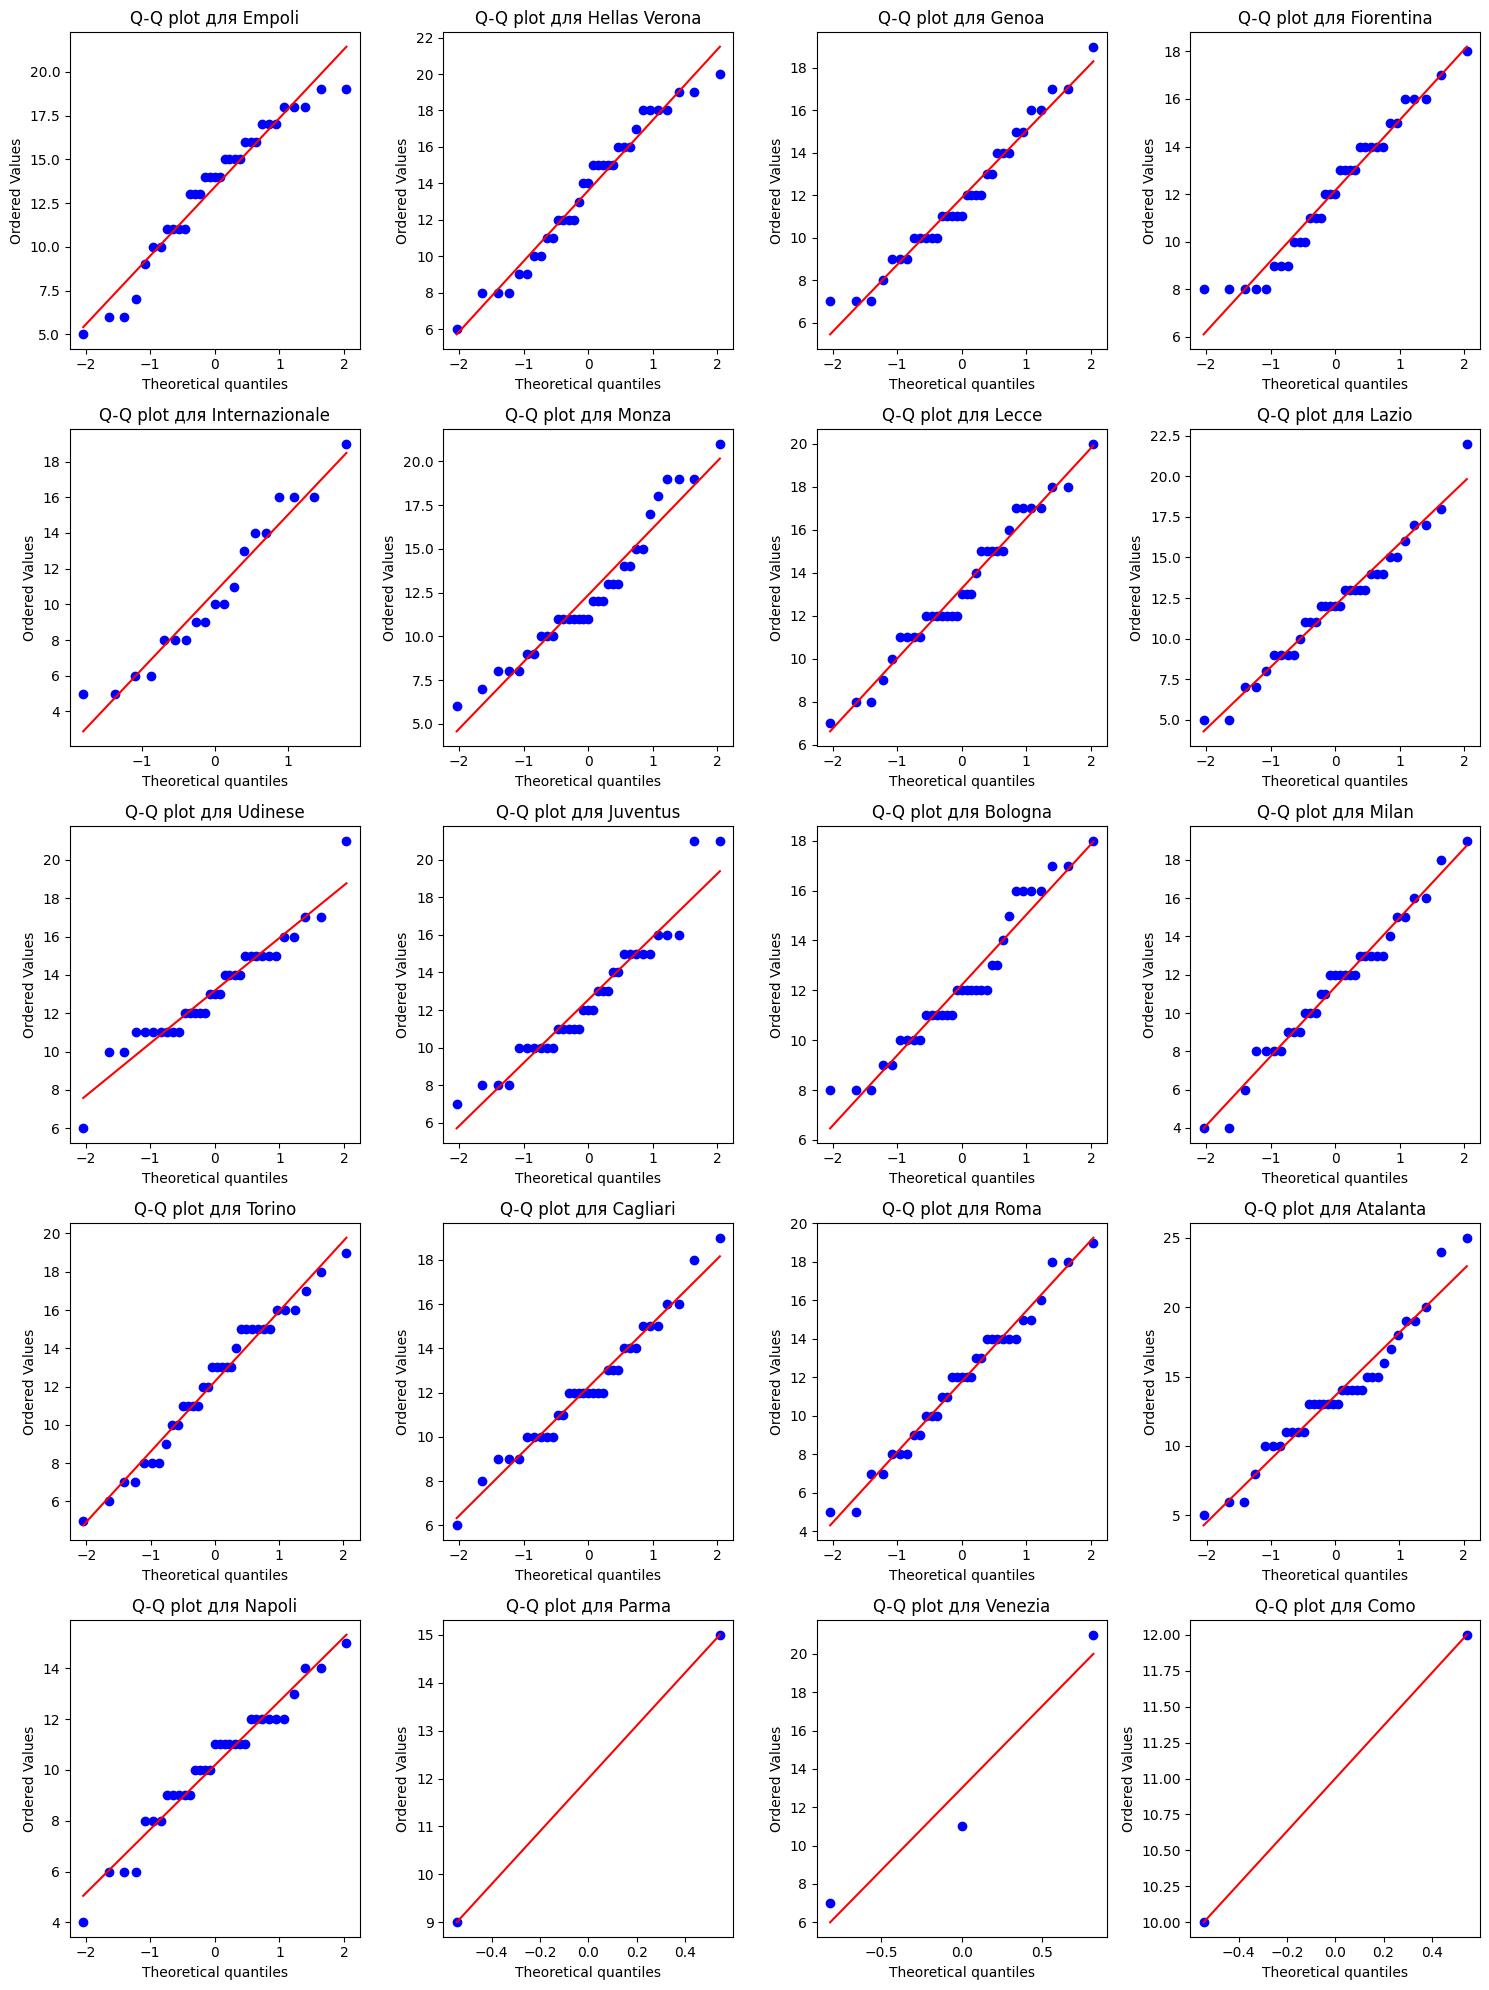

In [10]:
import scipy.stats as stats
import matplotlib.pyplot as plt



# Создаём сетку графиков
n_teams = len(all_teams_fouls)
n_cols = 4  # Количество столбцов 
n_rows = (n_teams + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

# Индекс для перебора сабплотов
plot_index = 0

# Строим Q-Q plot для каждой команды
for team, fouls in all_teams_fouls.items():
    # Определяем текущие строку и столбец для сабплота
    row = plot_index // n_cols
    col = plot_index % n_cols

    # Строим Q-Q plot на текущем сабплоте
    stats.probplot(fouls, dist="norm", plot=axes[row, col])  #  !!! Используем axes[row, col]
    axes[row, col].set_title(f'Q-Q plot для {team}')

    plot_index += 1

# Удаляем пустые сабплоты
if plot_index < n_rows * n_cols:
    for i in range(plot_index, n_rows * n_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [ ]:
Далее, будем доставать таблицу для предсказаний следующих 10 игр.

In [12]:
df_to_clear['Date'] = pd.to_datetime(df_to_clear['Date'])
#указываем дату
today = '2024-08-31'
new_tour = df_to_clear[(df_to_clear['fouls_home'].isna()) & (df_to_clear['Date'] >= today)][:10].drop(['fouls_home', 'fouls_away', 'Referee'], axis=1)
new_tour

,Date,Home,Away
383,2024-08-31,Lecce,Cagliari
384,2024-08-31,Bologna,Empoli
385,2024-08-31,Lazio,Milan
386,2024-08-31,Napoli,Parma
387,2024-09-01,Fiorentina,Monza
388,2024-09-01,Genoa,Hellas Verona
389,2024-09-01,Udinese,Como
390,2024-09-01,Juventus,Roma
391,2024-09-15,Cagliari,Napoli
392,2024-09-15,Como,Bologna


Создадим доверительные интервалы для разницы фолов и тотала фолов в каждом матче

In [14]:
import scipy.stats as st
def get_confidence_interval(data1, data2, confidence=0.90):
    n1 = len(data1)
    n2 = len(data2)
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    std1 = np.std(data1, ddof=1)  # ddof=1 для несмещенной оценки дисперсии
    std2 = np.std(data2, ddof=1)
    se = np.sqrt(std1**2 / n1 + std2**2 / n2)
    t_value = st.t.ppf((1 + confidence) / 2, df=min(n1, n2) - 1)
    margin_of_error = t_value * se
    return (mean1 - mean2 - margin_of_error, mean1 - mean2 + margin_of_error)


# Цикл по строкам DataFrame
for index, row in new_tour.iterrows():
    home_team = row['Home']
    away_team = row['Away']

    # Получаем данные о фолах для команд
    home_fouls = all_teams_fouls.get(home_team, [])
    away_fouls = all_teams_fouls.get(away_team, [])

    if home_fouls and away_fouls:
        # Расчет доверительных интервалов
        conf_interval_diff = get_confidence_interval(home_fouls, away_fouls)
        conf_interval_sum = get_confidence_interval(home_fouls, [-x for x in away_fouls]) 

        # Добавляем результаты в DataFrame, создавая отдельные столбцы
        new_tour.loc[index, 'diff_lower'] = conf_interval_diff[0]
        new_tour.loc[index, 'diff_upper'] = conf_interval_diff[1]
        new_tour.loc[index, 'sum_lower'] = conf_interval_sum[0]
        new_tour.loc[index, 'sum_upper'] = conf_interval_sum[1]

pd.set_option('display.max_colwidth', 12)
new_tour = new_tour[['Home', 'Away', 'diff_lower', 'diff_upper', 'sum_lower', 'sum_upper']]
print(new_tour)



           Home         Away  diff_lower  diff_upper  sum_lower  sum_upper
383       Lecce     Cagliari   -0.227870    2.288476  24.256978  26.773325
384     Bologna       Empoli   -2.625852    0.201609  24.222633  27.050094
385       Lazio        Milan   -0.816938    2.210877  21.910335  24.938150
386      Napoli        Parma  -20.954648   17.318284   3.045352  41.318284
387  Fiorentina        Monza   -1.622295    1.198052  23.104978  25.925325
388       Genoa  Hellas V...   -3.169373   -0.285173  24.042748  26.926949
389     Udinese         Como   -4.815156    9.178793  17.184844  31.178793
390    Juventus         Roma   -0.684810    2.199961  22.890948  25.775719
391    Cagliari       Napoli    0.948761    3.172451  21.312398  23.536087
392        Como      Bologna   -8.237648    5.813406  16.186594  30.237648


In [20]:
#для удобства достанем список судей
pd.set_option('display.max_colwidth', 30)
set(referee_stats[('Referee','')].sort_values())


{'Alberto Santoro',
 'Alessandro Prontera',
 'Andrea Colombo',
 'Antonio Giua',
 'Antonio Rapuano',
 'Daniele Chiffi',
 'Daniele Doveri',
 'Daniele Orsato',
 'Davide Di Marco',
 'Davide Ghersini',
 'Davide Massa',
 'Ermanno Feliciani',
 'Fabio Maresca',
 'Federico Dionisi',
 'Federico La Penna',
 'Francesco Cosso',
 'Francesco Fourneau',
 'Gianluca Aureliano',
 'Gianluca Manganiello',
 'Giovanni Ayroldi',
 'Giuseppe Collu',
 'Ivan Pezzuto',
 'Juan Sacchi',
 'Livio Marinelli',
 'Luca Massimi',
 'Luca Pairetto',
 'Luca Zufferli',
 'Marco Di Bello',
 'Marco Guida',
 'Marco Piccinini',
 'Maria Sole Ferrieri Caputi',
 'Matteo Marcenaro',
 'Matteo Marchetti',
 'Maurizio Mariani',
 'Michael Fabbri',
 'Paride Tremolada',
 'Rosario Abisso',
 'Simone Sozza'}

In [48]:
# к сожалению информацию о судьях приходится доставать вручную, поскольку она публикуется прямо перед матчами.
site = 'https://int.soccerway.com/'
new_tour_referees = ['Michael Fabbri','Livio Marinelli','Davide Massa','Paride Tremolada','Andrea Colombo', 'Giovanni Ayroldi','Alessandro Prontera','Marco Guida' ]
new_tour['Referee'] = new_tour_referees

# Сначала переименовываем столбцы, потом сбрасываем индекс
referee_stats_for_merging = referee_stats.copy()
referee_stats_for_merging.columns = ['Referee_', 'fouls_total_count', 'fouls_total_mean', 'mean_of_means_', 'mean_dif_', 'fouls_diff_mean']
referee_stats_for_merging = referee_stats_for_merging.reset_index()

new_tour_with_referees = new_tour.merge(referee_stats_for_merging[['Referee_', 'fouls_total_mean', 'mean_of_means_','mean_dif_', ]], left_on ='Referee', right_on= 'Referee_').drop('Referee_', axis = 1)

new_tour_with_referees['sum_lower_corrected'] = new_tour_with_referees['sum_lower'] + new_tour_with_referees['mean_dif_']
new_tour_with_referees['sum_upper_corrected'] = new_tour_with_referees['sum_upper'] + new_tour_with_referees['mean_dif_']

print(new_tour_with_referees.to_string(index=False))

      Home          Away  diff_lower  diff_upper  sum_lower  sum_upper             Referee  fouls_total_mean  mean_of_means_  mean_dif_  sum_lower_corrected  sum_upper_corrected
     Lecce      Cagliari   -0.227870    2.288476  24.256978  26.773325      Michael Fabbri         24.750000       23.983878   0.766122            25.023100            27.539447
   Bologna        Empoli   -2.625852    0.201609  24.222633  27.050094     Livio Marinelli         24.375000       23.983878   0.391122            24.613755            27.441216
     Lazio         Milan   -0.816938    2.210877  21.910335  24.938150        Davide Massa         26.800000       23.983878   2.816122            24.726457            27.754272
    Napoli         Parma  -20.954648   17.318284   3.045352  41.318284    Paride Tremolada         25.666667       23.983878   1.682788             4.728140            43.001073
Fiorentina         Monza   -1.622295    1.198052  23.104978  25.925325      Andrea Colombo         23.866667  

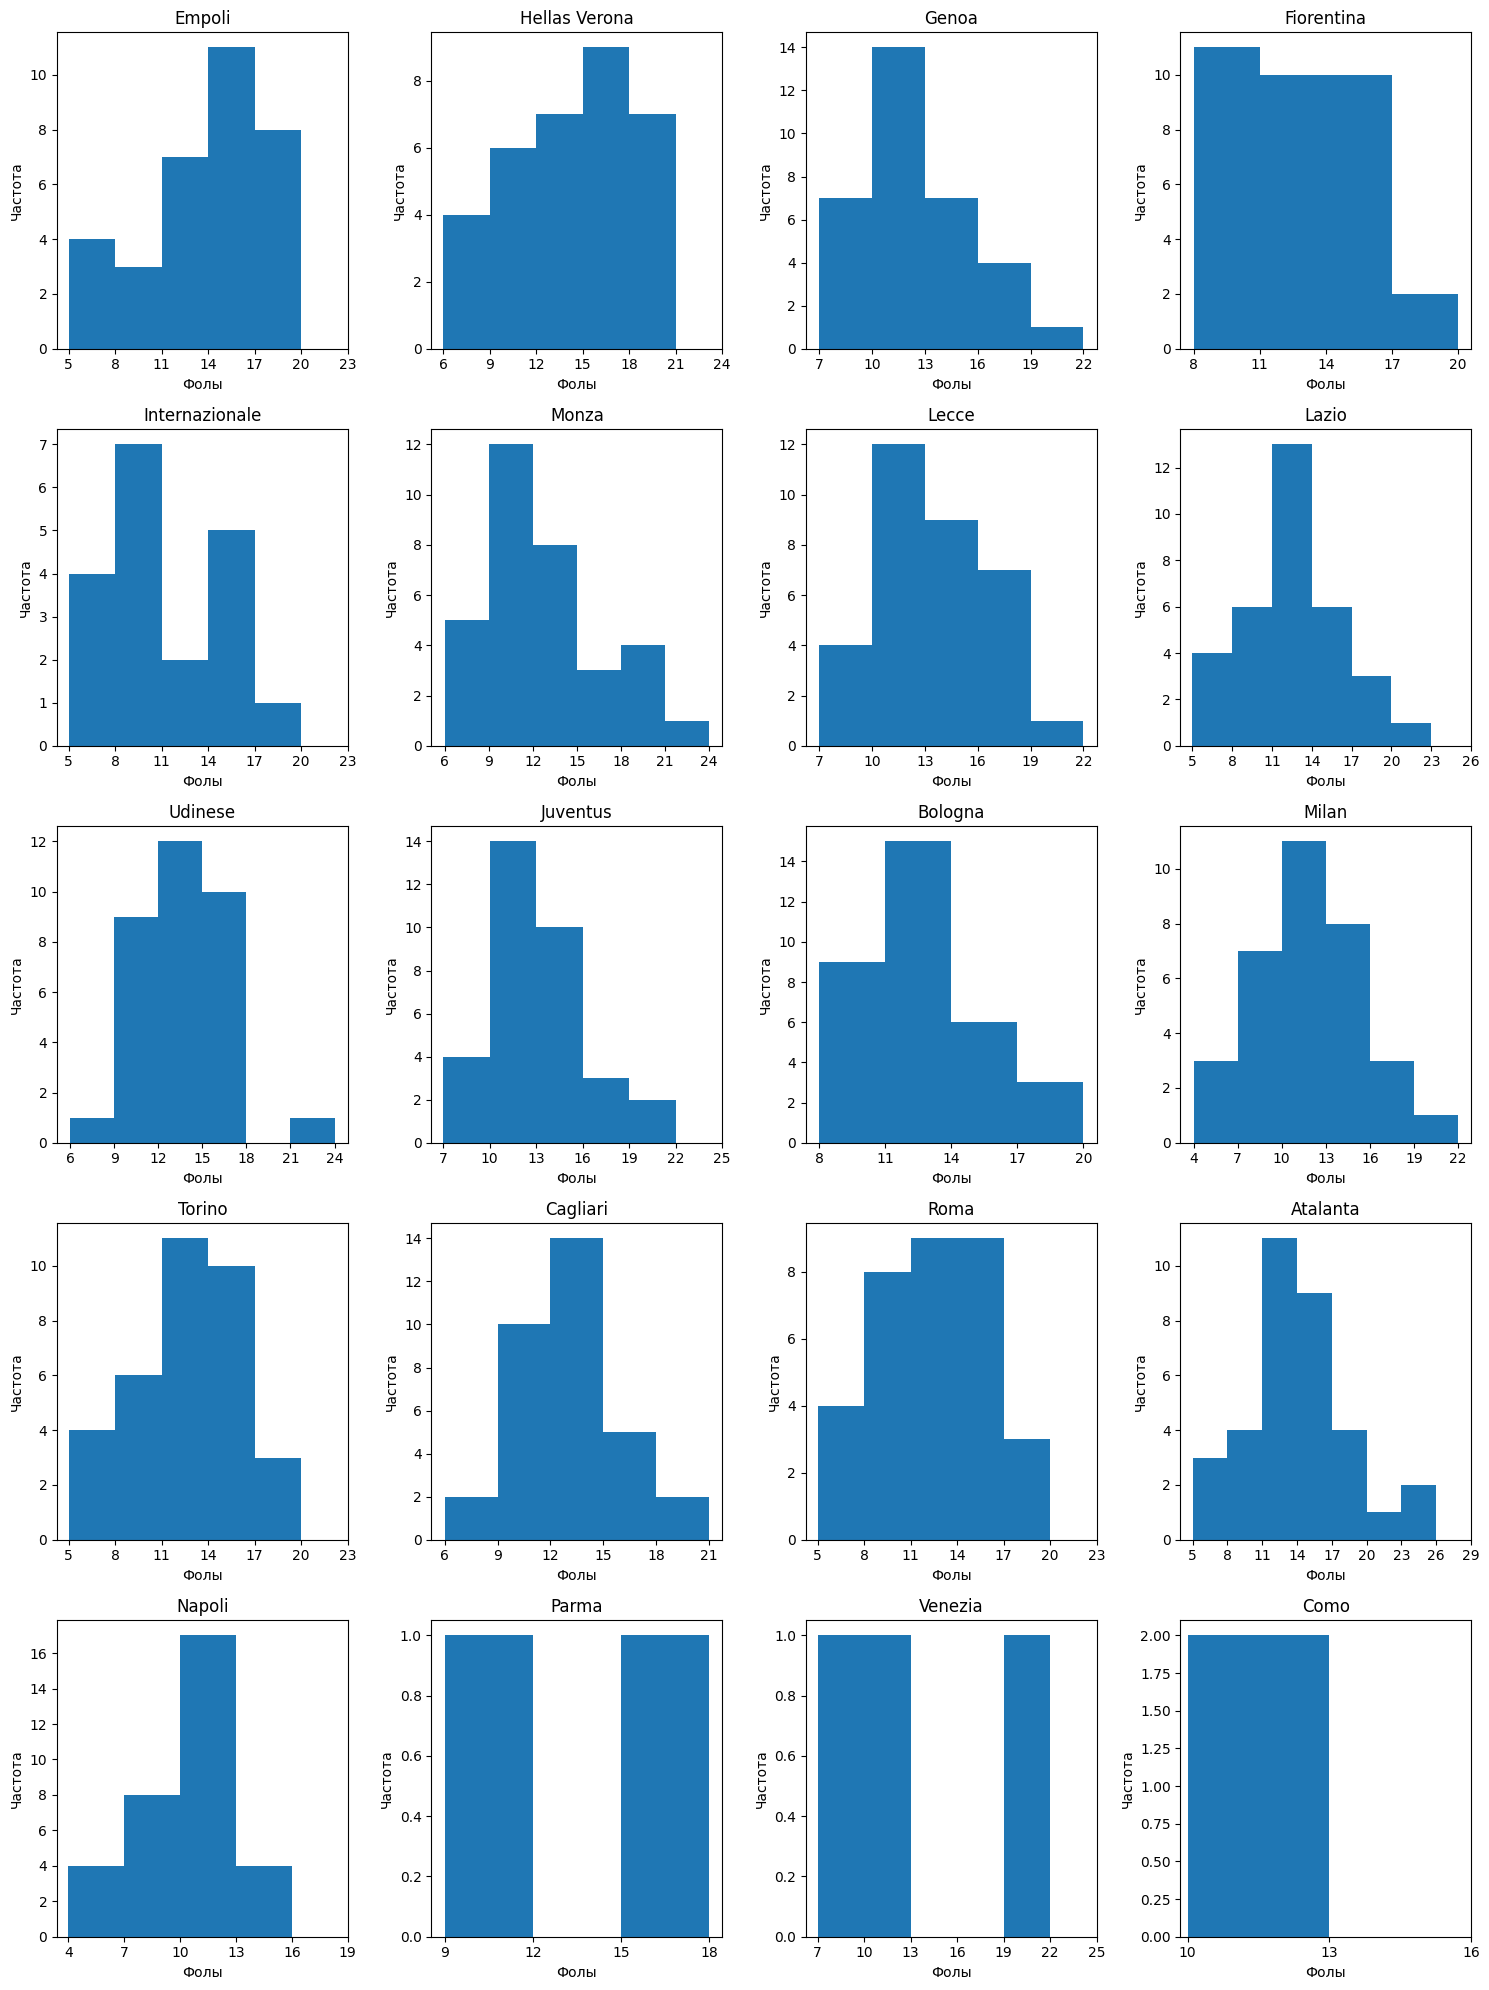

In [47]:
#построим дополнительно таблицу 
n_teams = len(all_teams_fouls)
n_cols = 4  # Количество столбцов 
n_rows = (n_teams + n_cols - 1) // n_cols  # Вычисляем количество строк

# Создаем фигуру и оси для сабплотов
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))

# Индекс для перебора сабплотов
plot_index = 0

# Строим гистограммы для каждой команды
for team, fouls in all_teams_fouls.items():
    # Определяем текущие строку и столбец для сабплота
    row = plot_index // n_cols
    col = plot_index % n_cols

    # Строим гистограмму на соответствующем сабплоте
    axes[row, col].hist(fouls, bins=range(int(min(fouls)), int(max(fouls)) + 4, 3))
    axes[row, col].set_title(f'{team}')
    axes[row, col].set_xlabel('Фолы')
    axes[row, col].set_ylabel('Частота')

    # Настраиваем шаг меток на оси X
    min_tick = min(fouls)
    max_tick = max(fouls) + 4 # Добавляем 4, чтобы последняя метка отображалась
    axes[row, col].set_xticks(np.arange(min_tick, max_tick + 1, 3))

    plot_index += 1

# Удаляем пустые сабплоты, если количество команд не кратно количеству столбцов
if plot_index < n_rows * n_cols:
    for i in range(plot_index, n_rows * n_cols):
        fig.delaxes(axes.flatten()[i])

# Настройка расположения сабплотов
plt.tight_layout()
plt.show()